In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from scipy.optimize import differential_evolution

from numba import njit, prange

In [2]:
#colors
DARK_RED = '#b30000'
RED = '#ff0000'
GRAY = '#bfbfbf'
BLUE = '#4d94ff'
DARK_BLUE = '#0066ff'

## Links
- Media Sources by Dem/Rep: https://www.journalism.org/2020/01/24/americans-are-divided-by-party-in-the-sources-they-turn-to-for-political-news/
- Most common platform for news by Dem/Rep: https://www.journalism.org/2020/01/24/election-news-pathways-project-frequently-asked-questions/#ideological-composition-of-news-outlets-audiences
- News from social media 2021: https://www.pewresearch.org/fact-tank/2021/01/12/more-than-eight-in-ten-americans-get-news-from-digital-devices/
- Number of sources by Dem/Rep: https://www.pewresearch.org/pathways-2020/MAINSOPOL_USE/political_party/us_adults
- News from social media 2020: https://www.journalism.org/2020/07/30/americans-who-mainly-get-their-news-on-social-media-are-less-engaged-less-knowledgeable/
- Most common platform by Dem/Rep: https://www.pewresearch.org/pathways-2020/NEWS_MOST/political_party/us_adults
- Paper about Social Media and news consumption: https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.20191777
- Daily news consumption: https://www.americanpressinstitute.org/publications/reports/survey-research/americans-news-consumption/

In [3]:
@njit(nogil=True)
def rand_choice_nb(arr, prob, num):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(num), side="right")]
        
#@njit(nogil=True, parallel=True)
def optimize_step(steps, agent_approval_values, num_agents, agent_approvals, consumption_rates, media_choices, uses_social_media, agent_late_night, 
                  agent_anti_late_night, approval_types, neg_persuadability, pos_persuadability,
                  threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, 
                  late_night_const=-1, late_night_jokes=0, use_late_night=True, contributions=np.array([])):
    if len(contributions) == 0:
        contrib = False
        media_array = np.zeros((0, ))
    else:
        contrib = True
        media_array = np.zeros((31, ))
    
    agent_storage = np.zeros((steps+1, 2, num_agents))
    agent_storage[0, 0] = agent_approval_values#.copy()
    agent_storage[0, 1] = agent_approvals#.copy()

    polling_history = np.zeros((steps, 2))
    for current_step in range(steps):
        for i in range(num_agents):
            second_rate = 0
            rate = 0
            if consumption_rates[i] < 1:
                rate = consumption_rates[i]
            elif consumption_rates[i] > 1:
                rate = 1
                second_rate = consumption_rates[i] - 1

            will_consume = np.random.rand() < rate#rand_choice_nb(np.array([True, False]), np.array([rate, 1-rate]))

            while will_consume:
                value = media_choices[i][current_step]
                if value is np.nan: break

                kernel = value + coverage_leaning - agent_approval_values[i]
                if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
                    if value > 0:
                        new_val = neg_persuadability[i] - (abs(kernel) * persuadability_scale)
                        if new_val < 0: new_val = 0
                        if new_val > 1: new_val = 1
                        neg_persuadability[i] = new_val

                    elif value < 0:
                        new_val = pos_persuadability[i] - (abs(kernel) * persuadability_scale)
                        if new_val < 0: new_val = 0
                        if new_val > 1: new_val = 1
                        pos_persuadability[i] = new_val

                elif value != 0:
                    p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
                    agent_approval_values[i] += p*kernel*alpha
                    if contrib:
                        media_array[int(contributions[i][current_step])] += p*kernel*alpha
                will_consume = np.random.rand() < second_rate#rand_choice_nb(np.array([True, False]), np.array([second_rate, 1-second_rate]))

            if uses_social_media[i]:
                p = pos_persuadability[i] if agent_approval_values[i] > 0 else neg_persuadability[i]
                x = np.abs(agent_approval_values[i])
                const = np.exp(-np.exp(1)*x) * social_media_const#(1-x)/(2*x+1)
                #const *= social_media_const
                agent_approval_values[i] += np.sign(agent_approval_values[i])*const * p
                if contrib:
                        media_array[-1] += np.sign(agent_approval_values[i])*const * p

                
            if use_late_night:
                #arbitrary percents from 0 to 6
                percents = [0, 0.8/30, 2/30, 1/10, 2/7, 4/7]

                #also arbitrary amount?
                #value = late_night_const
                per = percents[agent_late_night[i]]
                if np.random.rand() < per:#rand_choice_nb(np.array([True, False]), np.array([per, 1-per])):
                    kernel = (late_night_const * late_night_jokes) - agent_approval_values[i]
                    value = (late_night_const * late_night_jokes)
                    if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
                        if value > 0:
                            new_val = neg_persuadability[i] - (abs(kernel) * persuadability_scale)
                            if new_val < 0: new_val = 0
                            if new_val > 1: new_val = 1
                            neg_persuadability[i] = new_val

                        elif value < 0:
                            new_val = pos_persuadability[i] - (abs(kernel) * persuadability_scale)
                            if new_val < 0: new_val = 0
                            if new_val > 1: new_val = 1
                            pos_persuadability[i] = new_val

                    else:#if value != 0:
                        p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
                        agent_approval_values[i] += p*kernel*alpha
                        if contrib:
                            media_array[-2] += p*kernel*alpha
                        
                        
                
                #ANTI-LATENIGHT
                #value = -late_night_const
#                 if rand_choice_nb(np.array([True, False]), np.array([percents[agent_anti_late_night[i]], 1-percents[agent_anti_late_night[i]]])):
#                     kernel = (-late_night_const * late_night_jokes) - agent_approval_values[i]
#                     value = (-late_night_const * late_night_jokes)
#                     if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
#                         if value > 0:
#                             neg_persuadability[i] -= abs(kernel) * persuadability_scale
#                             if neg_persuadability[i] < 0: neg_persuadability[i] = 0
#                             if neg_persuadability[i] > 1: neg_persuadability[i] = 1
#                         elif value < 0:
#                             pos_persuadability[i] -= abs(kernel) * persuadability_scale
#                             if pos_persuadability[i] < 0: pos_persuadability[i] = 0
#                             if pos_persuadability[i] > 1: pos_persuadability[i] = 1

#                     else:#if value != 0:
#                         p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
#                         agent_approval_values[i] += p*kernel*alpha
#                         if contrib:
#                             media_array[-3] += p*kernel*alpha

            
            '''
            This should match the 0.2 step that we used to assign the approvals in the first place
            '''
#             w = np.where((agent_approval_values[i] < (media_values + threshold)) & (agent_approval_values[i] > (media_values - threshold)))[0]

#             if len(w):
#                 agent_approvals[i] = approval_types[w][0]

            if (0.6 < agent_approval_values[i]) & (agent_approval_values[i] <= 1):
                agent_approvals[i] = 1#'strongly approve'
            elif (0.2 < agent_approval_values[i]) & (agent_approval_values[i] <= 0.6):
                agent_approvals[i] = 2#'somewhat approve'
            elif (-0.2 < agent_approval_values[i]) & (agent_approval_values[i] <= 0.2):
                agent_approvals[i] = 5#'no opinion'
            elif (-0.6 < agent_approval_values[i]) & (agent_approval_values[i] <= -0.2):
                agent_approvals[i] = 3#'somewhat disapprove'
            elif (-1 <= agent_approval_values[i]) & (agent_approval_values[i] <= -0.6):
                agent_approvals[i] = 4#'strongly disapprove'
            
                
        agent_storage[current_step+1, 0] = agent_approval_values.copy() 
        agent_storage[current_step+1, 1] = agent_approvals.copy() 
        
        approve = 0
        disapprove = 0
        no_opinion = 0
        for i in range(num_agents):
            if agent_approvals[i] == approval_types[0] or agent_approvals[i] == approval_types[1]:
                approve += 1
            elif agent_approvals[i] == approval_types[2] or agent_approvals[i] == approval_types[3]:
                disapprove += 1
            else:
                no_opinion += 1
        polling_history[current_step] = [100*approve/num_agents, 100*disapprove/num_agents]
    
    
    return polling_history, media_array, agent_storage#, 100*no_opinion/num_agents]

In [59]:
'''Preprocess the random choices and values, and then vectorize the agent calculations'''
steps = 30


#@njit("(f8[:], f8[:], f8[:], f8[:], f8[:], f8, f8, f8)", nogil=True)
def vectorize_sim(media_choices, LN_choices, aav, neg_persuadability, pos_persuadability, alpha, persuadability_scale, social_media_const):
    coverage_leaning = 0
    #media update
    kernel = media_choices + coverage_leaning - aav
    mask = (np.sign(media_choices) == np.sign(aav)) & (np.abs(media_choices) < np.abs(aav))
    n_mask = mask & (media_choices > 0)
    p_mask = mask & (media_choices < 0)
    neg_persuadability[n_mask] -= (np.abs(kernel[n_mask]) * persuadability_scale)
    pos_persuadability[p_mask] -= (np.abs(kernel[p_mask]) * persuadability_scale)
    kp_mask = (kernel > 0) & (~mask)
    kn_mask = (kernel <= 0) & (~mask)
    aav[kp_mask] += pos_persuadability[kp_mask]*kernel[kp_mask]*alpha
    aav[kn_mask] += neg_persuadability[kn_mask]*kernel[kn_mask]*alpha
    
    #social media update
    p_sm = aav > 0
    aav[p_sm] += np.sign(aav[p_sm])* np.exp(-np.e*np.abs(aav[p_sm])) * social_media_const * pos_persuadability[p_sm]
    n_sm = aav <= 0
    aav[n_sm] += np.sign(aav[n_sm])* np.exp(-np.e*np.abs(aav[n_sm])) * social_media_const * neg_persuadability[n_sm]

    
    #late night update
    kernel = LN_choices - aav
    mask = (np.sign(LN_choices) == np.sign(aav)) & (np.abs(LN_choices) < np.abs(aav))
    n_mask = mask & (LN_choices > 0)
    p_mask = mask & (LN_choices < 0)
    neg_persuadability[n_mask] -= (np.abs(kernel[n_mask]) * persuadability_scale)
    pos_persuadability[p_mask] -= (np.abs(kernel[p_mask]) * persuadability_scale)
    kp_mask = (kernel > 0) & (~mask)
    kn_mask = (kernel <= 0) & (~mask)
    aav[kp_mask] += pos_persuadability[kp_mask]*kernel[kp_mask]*alpha
    aav[kn_mask] += neg_persuadability[kn_mask]*kernel[kn_mask]*alpha

    return aav, neg_persuadability, pos_persuadability

@njit("(f8[:], f8[:], f8[:], f8[:], f8[:], f8, f8, f8)", nogil=True, parallel=True)
def sim_parallel(media_choices, LN_choices, aav, neg_persuadability, pos_persuadability, alpha, persuadability_scale, social_media_const):
    coverage_leaning = 0
    for i in prange(len(aav)):
        
        mc = media_choices[i]
        av = aav[i]
        ln = LN_choices[i]
        p_p = pos_persuadability[i]
        n_p = neg_persuadability[i]
        if mc != np.inf:
            if np.sign(mc) == np.sign(av) and abs(mc) < abs(av):
                if mc > 0:
                    neg_persuadability[i] -= abs(mc-av) * persuadability_scale
                    if neg_persuadability[i] < 0: neg_persuadability[i] = 0
                    if neg_persuadability[i] > 1: neg_persuadability[i] = 1
                else:
                    pos_persuadability[i] -= abs(mc-av) * persuadability_scale
                    if pos_persuadability[i] < 0: pos_persuadability[i] = 0
                    if pos_persuadability[i] > 1: pos_persuadability[i] = 1
            else:
                p = p_p if mc > av else n_p
                aav[i] += (mc + coverage_leaning - av)*p*alpha
        #social media
        p = p_p if av > 0 else n_p
        aav[i] += np.sign(av)* np.exp(-np.e*np.abs(av)) * social_media_const * p

        if ln != np.inf:
            if np.sign(ln) == np.sign(av) and abs(ln) < abs(av):
                if ln > 0:
                    neg_persuadability[i] -= abs(ln-av) * persuadability_scale
                    if neg_persuadability[i] < 0: neg_persuadability[i] = 0
                    if neg_persuadability[i] > 1: neg_persuadability[i] = 1
                else:
                    pos_persuadability[i] -= abs(ln-av) * persuadability_scale
                    if pos_persuadability[i] < 0: pos_persuadability[i] = 0
                    if pos_persuadability[i] > 1: pos_persuadability[i] = 1
            else:
                p = p_p if ln > av else n_p
                aav[i] += (ln - av)*p*alpha

        #dif = abs(aav[i] - av)
        
    return aav, neg_persuadability, pos_persuadability


@njit("f8[:, :](f8[:, :], f8[:])", nogil=True)#, parallel=True)
def choose_media(arr, vals):
    num = len(arr)
    media_choices = np.full((num, steps), np.inf)
    for i in range(num): 
        row = arr[i]
        nonzero = row.nonzero()[0]
        if len(nonzero) == 0: 
            continue
        media_choices[i] = rand_choice_nb(vals[nonzero], np.full(len(nonzero), 1/len(nonzero)), steps)

    return media_choices

            
@njit("(f8[:, :], f8[:, :], f8[:], f8[:], f8[:], f8, f8, f8)")
def run_sim(media_choices, LN_choices, aav, neg_persuadability, pos_persuadability, alpha, persuadability_scale, social_media_const):
    index = 0
    for step in range(steps):
        sim_parallel(media_choices[:, step], LN_choices[:, step], aav, neg_persuadability, pos_persuadability, alpha, persuadability_scale, social_media_const)
    return aav
            
            
def randomize_media(x, vals):
    try:
        index = np.random.choice(x.nonzero()[0], len(x))
        steps = np.zeros(len(x))
        steps[index] = vals[index]
    except:
        return np.full(len(x), np.inf)
    return x

def get_approval_percent(aav):
    total = len(aav)
    disapprove = 100*len(np.nonzero(aav < -0.2)[0])/total
    approve = 100*len(np.nonzero(aav > 0.2)[0])/total
    no_op = 100 - approve - disapprove
    return approve, disapprove, no_op


In [60]:
def simulate(args, LN_jokes):
    model = Model(media_outlets, media_distributions, approval_distributions, party_distributions, sm_distributions, weights_by_cat)
    late_night_const = args[-1]
    (alpha, persuadability_scale, social_media_const) = args[:-1]
    aav = model.agent_approval_values
    vals = np.array([m.get_value() for m in model.media], dtype=float)

    media_choices = choose_media(model.media_choices, vals)
    denom = np.exp(2)-1
    neg_persuadability = (np.exp(-aav+1)-1)/denom
    pos_persuadability = (np.exp(aav+1)-1)/denom    

    LN_choices = np.full((model.num_agents, steps), np.inf)
    percents = np.array([0, 0.8/30, 2/30, 1/10, 2/7, 4/7])
    rands = np.random.rand(model.num_agents, steps)

    per = percents[model.agent_late_night].reshape(-1, 1)
    LN_choices[rands < per] = (late_night_const * LN_jokes)
    
    result = run_sim(media_choices, LN_choices, aav, neg_persuadability, pos_persuadability, alpha, persuadability_scale, social_media_const)
    return result

simulate((0.01, 0.01, 0.9, -0.02), 4.2)

array([ 1.30285537, -1.4735394 , -1.6004048 , ..., -1.65350763,
       -1.60683925, -1.59183443])

In [61]:
%time simulate((0.01, 0.01, 0.9, -0.02), 4.2)

Wall time: 9.45 s


array([ 1.13889128,  1.59172197, -1.60241481, ..., -1.65851801,
       -1.65320691, -1.62122808])

In [64]:
(alpha, persuadability_scale, social_media_const, late_night_const) = args#list(best.values())#(0.1, 0.01, 0.09, -0.02)
LN_jokes = 4.2
model = Model(media_outlets, media_distributions, approval_distributions, party_distributions, sm_distributions, weights_by_cat)

aav = model.agent_approval_values
vals = np.array([m.get_value() for m in model.media], dtype=float)

media_choices = choose_media(model.media_choices, vals)
denom = np.exp(2)-1
neg_persuadability = (np.exp(-aav+1)-1)/denom
pos_persuadability = (np.exp(aav+1)-1)/denom    

LN_choices = np.full((model.num_agents, steps), np.inf)
percents = np.array([0, 0.8/30, 2/30, 1/10, 2/7, 4/7])
rands = np.random.rand(model.num_agents, steps)

per = percents[model.agent_late_night].reshape(-1, 1)
LN_choices[rands < per] = (late_night_const * LN_jokes)

percents = np.zeros((steps, 3))
for step in range(steps):
    sim_parallel(media_choices[:, step], LN_choices[:, step], aav, neg_persuadability, pos_persuadability, alpha, persuadability_scale, social_media_const)
    percents[step] = get_approval_percent(aav)

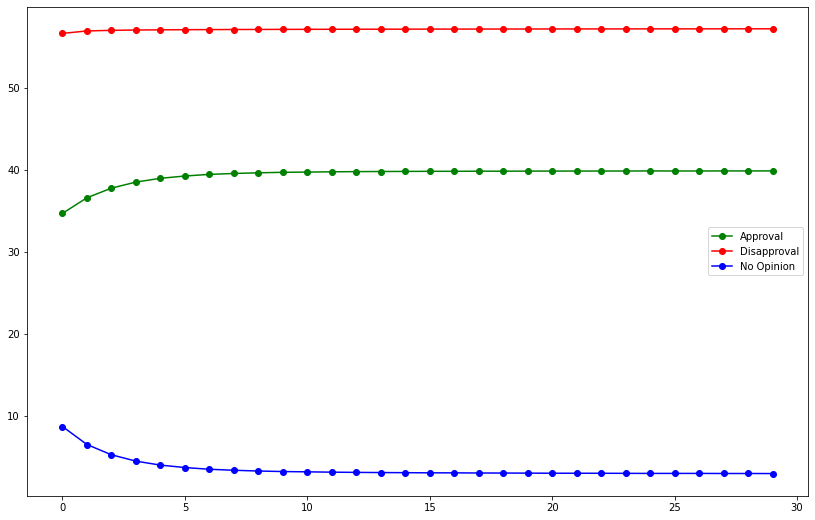

In [65]:
plt.figure(figsize=(14, 9))
r = range(steps)
plt.plot(r, percents[:, 0], 'o-', c='g', label='Approval')
plt.plot(r, percents[:, 1], 'o-', c='r', label='Disapproval')
plt.plot(r, percents[:, 2], 'o-', c='b', label='No Opinion')
plt.legend()
plt.show()

In [250]:
%lprun -f choose_media choose_media(model.num_agents, model.media_choices, vals)

*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-07 s

Total time: 106.754 s
File: <ipython-input-249-0efb4bfa7fa1>
Function: choose_media at line 42

Line #      Hits         Time  Per Hit   % Time  Line Contents
    42                                           def choose_media(num, a, vals):
    43         1    1223559.0 1223559.0      0.1      media_choices = np.full((num, steps), np.inf)
    44   1867930    6034761.0      3.2      0.6      for i in range(len(a)): 
    45   1867930    9754298.0      5.2      0.9          row = a[i]
    46   1867930   17060013.0      9.1      1.6          nonzero = row.nonzero()[0]
    47   1867930    9134338.0      4.9      0.9          if len(nonzero) == 0: 
    48     44258     132915.0      3.0      0.0              continue
    49   1823672   95228625.0     52.2      8.9          p = np.full(len(nonzero), 1/len(nonzero))
    50  56533822  181213968.0      3.2     17.0          for j in range(steps):
    51  54710151  747753502.0     13.7     70.0              media_choices[i, j]

In [47]:
from hyperopt import hp, fmin, tpe, space_eval

In [62]:
def f(x):
    target = [42, 52, 6]
    late_night_jokes = 4.202088452088452
    
    args = (x['alpha'], x['persuadability_scale'], x['social_media_const'], x['late_night_const'])
    result = get_approval_percent(simulate(args, late_night_jokes))
    loss = 0
    for j in range(len(result)):
        loss += abs(result[j] - target[j])**2
    loss /= len(result)
    #print(f"\r Loss: {loss:.4f}", end=' ', flush=True)
    return loss

space = {
    'alpha': hp.uniform('alpha', 0, 1.5),
    'persuadability_scale' : hp.uniform('persuadability_scale', 0, 1.5),
    'social_media_const' : hp.uniform('social_media_const', 0, 1.5),
    'late_night_const' : hp.uniform('late_night_const', -1.5, 0)
}


# minimize the objective over the space
best = fmin(f, space, algo=tpe.suggest, max_evals=100)

print(best)

100%|██████████| 100/100 [16:16<00:00,  9.77s/trial, best loss: 13.724182499382811]
{'alpha': 0.5829118164885608, 'late_night_const': -0.0833689652971582, 'persuadability_scale': 0.26662678932103634, 'social_media_const': 0.38650851255156554}


In [63]:
args = (best['alpha'], best['persuadability_scale'], best['social_media_const'], best['late_night_const'])

In [7]:
#make media classes
class MediaOutlet:
    def __init__(self, name, political_leaning, mcb_ideology):#, mcb_education, mcb_age)
        self.name = name
        self.political_leaning = political_leaning #negative is left, pos is right
        
        #Media Consumption by...
        self.mcb_ideology = mcb_ideology#[dem, Dlean, Rlean, rep]  % of that group that consumes

    def __str__(self):
        return self.name
     
    def get_value(self):
        return self.political_leaning    
    

In [8]:
#make agent class
class Agent:
    def __init__(self, approval, ideology, approval_value):
        self.assigned_media_sources = []
        self.consumption_rate = 0

        #demographic information
        self.approval = approval
        self.ideology = ideology
        
        self.approval_value = approval_value
        
        #using this set up gives us a steeper curve than above and also accounts for values outside of the bounds -1, 1
            #at 0 the persuadability is 0.269 rather then 0.5
        denom = np.exp(2)-1
        self.neg_persuadability = (np.exp(-approval_value+1)-1)/denom
        self.pos_persuadability = (np.exp(approval_value+1)-1)/denom
        
        self.uses_social_media = False
        
        self.late_night = 0
        self.anti_late_night = 0
       
    
    def assign(self, media_outlet):
        self.assigned_media_sources.append(media_outlet)
        
        
    def stats(self):
        print(f'Ideology: {self.ideology}\nApproval: {self.approval}')

        print('\tMedia Sources: ', end='')
        for m in self.assigned_media_sources:
            print(m, end=', ')
        
        print(f'\n\tConsumption Frequency: {self.consumption_rate}', end='')
        
        oftenness = ['Never', 'Less than Once a Month', 'About Once a Month', 'Several Times a Month', 'Once a Week', 'Multiple Times A Week']
        print(f'\nWatches Late-Night: {oftenness[self.late_night]}')
        print(f'\nUses Social Media: {self.uses_social_media}')
            
    def consume_media(self):
        #return all the media bias values 
        return [m.get_value() for m in self.assigned_media_sources]

In [51]:
class Model:
    def __init__(self, media_array, media_distributions, approval_distributions, party_distributions, sm_distributions, weights_by_cat):     
        media_names = list(media_distributions.index)
        self.media = np.empty(len(media_names), dtype=object)
        for m in media_array:
            index = media_names.index(m.name)
            self.media[index] = m
        #{name: media_array[media_array.index()] for name in list(media_distributions.index)}
        #self.agents = [None]*int(weights_by_cat.sum(axis=1))
        #self.agent_approval_values = data['Opinion of Trump'].to_numpy()#np.zeros((num_agents, ))
        self.generate_agents(media_distributions.to_numpy(), approval_distributions.to_numpy(), 
                             party_distributions.to_numpy(), sm_distributions.to_numpy().reshape(-1), weights_by_cat.to_numpy().reshape(-1))
        
        #self.agent_approval_values = np.array([m.approval_value for m in self.agents])
#         self.starting_state = self.agent_approval_values.copy()
#         self.starting_agent_op = self.agent_approvals.copy()
        
        
    def generate_agents(self, media_distributions, approval_distributions, party_distributions, sm_distributions, weights_by_cat):
        count = 0
        
        self.num_agents = int(weights_by_cat.sum())
        self.rates = np.random.choice([1.75, 1.25, 0.75, 0], self.num_agents, p=[.39, .29, .3, .02])
        
        self.agent_approval_values = np.zeros((self.num_agents))
        self.agent_approvals = np.zeros((self.num_agents), dtype=int)
        self.uses_social_media = np.zeros((self.num_agents), dtype=bool)
        self.agent_late_night = np.zeros((self.num_agents), dtype=int)
        self.media_choices = np.zeros((self.num_agents, len(media_distributions)))
        
        bins = len(approval_distributions)
        step = 2/bins
        
        cat_count = 1
        
        for num in weights_by_cat.astype(int):
            cat = int(cat_count)
            probs = party_distributions[:, cat-1]
            offset = 1-probs.sum()
            probs[2] += offset
            party_choices = np.random.choice([1, 2, 3], (num), p=probs)#['Democrat', 'Republican', 'Independent']

            
            col = approval_distributions[:, cat-1]
            
            offset = 1-col.sum()
            col[3] += offset
            approval_value_choices = np.random.choice(range(bins), num, p=col)
            approval_value_choices = (-1 + (approval_value_choices * step) + ((2*np.random.rand(len(approval_value_choices)))/bins))
            
            opinion_choices = np.zeros(num, dtype=int)#np.array(['']*num, dtype=object)
            opinion_choices[(0.6 < approval_value_choices) & (approval_value_choices <= 1)] = 1#'strongly approve'
            opinion_choices[(0.2 < approval_value_choices) & (approval_value_choices <= 0.6)] = 2#'somewhat approve'
            opinion_choices[(-0.2 < approval_value_choices) & (approval_value_choices <= 0.2)] = 5#'no opinion'
            opinion_choices[(-0.6 < approval_value_choices) & (approval_value_choices <= -0.2)] = 3#'somewhat disapprove'
            opinion_choices[(-1 <= approval_value_choices) & (approval_value_choices <= -0.6)] = 4#'strongly disapprove'
            
            dist = media_distributions[:, cat-1]
            
            rand = np.random.rand(num, len(dist))
            #media_objects = np.array(self.media).reshape(-1)
            self.media_choices[count:count+num] = (rand < dist.reshape(1, -1))#.astype(int)#.extend([list(self.media[a]) for a in rand < dist.reshape(1, -1)]) #media_objects[a]
            
            
            

            LN_rand = np.random.rand(num)
            
            LN = np.zeros((num,), dtype=int)
            dem_mask = (party_choices == 1) & (LN_rand < 0.54)#'Democrat'
            LN[dem_mask] = np.random.choice([5, 4, 3, 2, 1, 0], np.count_nonzero(dem_mask), p=[.51, .18, .15, .05, .06, .05])
            
            rep_mask = (party_choices == 2) & (LN_rand < 0.26)#'Republican'
            LN[rep_mask] = np.random.choice([5, 4, 3, 2, 1, 0], np.count_nonzero(rep_mask), p=[.35, .18, .20, .10, .12, .05])
            
            ind_mask = (party_choices == 3) & (LN_rand < 0.34)#'Independent'
            LN[ind_mask] = np.random.choice([5, 4, 3, 2, 1, 0], np.count_nonzero(ind_mask), p=[.35, .17, .22, .10, .09, .07])
            
            sm_rand = np.random.rand(num)
            
            
            self.agent_approval_values[count:count+num] = approval_value_choices
            self.agent_approvals[count:count+num] = opinion_choices
            self.uses_social_media[count:count+num] = sm_rand < sm_distributions[cat-1]
            self.agent_late_night[count:count+num] = LN
            count += num
            #make num copies of this person
#             for j in range(num):
#                 self.agents[count] = Agent(opinion_choices[j], party_choices[j], approval_value_choices[j]) 
#                 self.agents[count].uses_social_media = sm_rand[j] < sm_distributions[cat-1] 
#                 self.agents[count].assigned_media_sources = self.media_choices[j]
#                 self.agents[count].late_night = LN[j]
#                 self.agents[count].consumption_rate = rates[count]
#                 count += 1
        
            cat_count += 1
        

#         def randomize_media(x, vals):
#             try:
#                 index = np.random.choice(x.nonzero()[0], len(x))
#                 steps = np.zeros(len(x))
#                 steps[index] = vals[index]
#             except:
#                 return np.full(len(x), np.nan)
#             return x
        
#         def simulate(args, late_night_jokes = 4.202088452088452, coverage_density = 0.05):
#             (threshold, alpha, persuadability_scale, social_media_const, late_night_const) = args#[ 0.01877369,  0.07156605,  0.82809562,  1.30110476, -0.31278901]
            
            
#             steps = 30
#             starting_state = self.agent_approval_values

#             approval_types = np.array([1, 2, 3, 4, 5], dtype=int)#'strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'], dtype=np.str_)
#             #dic = {'strongly approve': 1, 'somewhat approve': 2, 'somewhat disapprove': 3, 'strongly disapprove': 4, 'no opinion':5}
#             #agent_approvals = np.vectorize(dic.__getitem__)(self.agent_approvals)
#             denom = np.exp(2)-1
            
#             assert(len(self.media_choices[0]) <= steps)
#             vals = [m.get_value() for m in self.media]
#             media_values = np.concatenate((self.media_choices, np.zeros((len(self.media_choices), steps-len(self.media_choices[0])))), axis=1)
#             test = np.apply_along_axis(randomize_media, 1, media_values, vals)
#             print(test[0])
            
# #             rand_media = np.array([np.random.randint(0, len(media), (steps,)) if len(media) > 0 else np.zeros((steps,)) for media in self.media_choices], dtype=int)
# #             media_values = np.array([np.array([media[rand_media[i, step]].get_value() if len(media) > 0 else 0 for step in range(steps)]) for i, media in enumerate(self.media_choices)], dtype=float)
            
# #             test = list(self.media)
# #             media_contributions = np.array([np.array([test.index(media[rand_media[i, step]]) if len(media) > 0 else 0 for step in range(steps)]) for i, media in enumerate(self.media_choices)], dtype=int)
#             consumption_rates = self.rates
#             neg_persuadability = (np.exp(-starting_state+1)-1)/denom
#             pos_persuadability = (np.exp(starting_state+1)-1)/denom
#             agent_anti_late_night = []
            
#             result, media_array, storage = optimize_step(steps, starting_state, self.num_agents, self.agent_approvals, consumption_rates, media_values, self.uses_social_media, 
#                       self.agent_late_night, np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
#                       threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_density, social_media_const=social_media_const, 
#                       late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True, contributions=media_contributions)
    
#             return result, media_array, storage
        
        
#         self.simulate = simulate
            
            
            
#     def media_landscape(self):
#         #describe how the media outlets inputted are distributed politcally and how many people watch them
#         #x is leaning, y is number of agents that use it
        
#         plt.figure(figsize=(15, 10))
#         y = np.zeros((len(self.media), ))
#         names = [media.name for media in self.media]
        
#         for choice in self.media_choices:
#             for media in choice:
#                 y[names.index(media.name)] += 1
            
#         biases = [media.get_value() for media in self.media]
        
#         for i in range(len(self.media)):
#             plt.scatter(biases[i], y[i])
#             plt.text(biases[i]+0.03, y[i]+0.03, names[i])
#        #plt.subplot(121)
#         #plt.bar(range(len(self.media_array)), y, label=[media.name for media in self.media_array])
#         #plt.xticks(ticks=range(len(self.media_array)), labels=[media.name for media in self.media_array], rotation='vertical')
#         plt.xlabel("Bias")
#         plt.ylabel("Audience Size")

#         plt.show()
#         print('Mean of Biases:', np.mean(biases))
#         print('Number of Sources:', len(self.media))
#         print('Aggregate Score:', np.sum(biases*y)/self.num_agents)

In [10]:
#Model(data, media_outlets, media_distributions, approval_distributions, party_distributions, sm_distributions, weights_by_cat).simulate(args)

In [11]:
                    '''political_leaning, mcb_ideology'''
    

CNN = MediaOutlet("CNN", -8.98, [57, 50, 32, 19])
MSNBC = MediaOutlet("MSNBC", -13.94, [38, 30, 17, 12])
HuffPost = MediaOutlet("HuffPost", -11.0, [18, 8, 3, 3])
Vice = MediaOutlet("Vice", -10.61, [])
BuzzFeed = MediaOutlet("BuzzFeed", -7.9, [])
Vox = MediaOutlet("Vox", -10.57, [])

NBC = MediaOutlet("NBC News", -7.42, [39, 40, 32, 25])
ABC = MediaOutlet("ABC News", -4.65, [32, 42, 36, 26])
CBS = MediaOutlet("CBS News", -3.49, [30, 36, 29, 24])
PBS = MediaOutlet("PBS", -4.84, [])


WashingtonPost = MediaOutlet("Washington Post", -7.82, [33, 20, 9, 8])
NewYorkTimes = MediaOutlet("The New York Times", -8.19, [42, 22, 12, 8])
Politico = MediaOutlet("Politico", -6.9, [20, 9, 6, 5])
Time = MediaOutlet("Time", -9.72, [11, 9, 5, 3])
TheGuardian = MediaOutlet("The Guardian", -9.77, [13, 4, 4, 3])


NPR = MediaOutlet("NPR", -4.94, [43, 20, 13, 9])
BBC = MediaOutlet("BBC", -2.67, [29, 16, 13, 8])
WallStreetJournal = MediaOutlet("The Wall Street Journal", 4.93, [17, 13, 11, 11])
USAToday = MediaOutlet("USA Today", -4.0, [12, 14, 12, 8])
TheHill = MediaOutlet("The Hill", -0.5, [11, 5, 4, 5])
Newsweek = MediaOutlet("Newsweek", -6.28, [8, 7, 4, 3])

NewYorkPost = MediaOutlet("New York Post", 12.75, [5, 5, 4, 6])
WashingtonExaminer = MediaOutlet("Washington Examiner", 15.04, [1, 2, 3, 4])

FoxNews = MediaOutlet("Fox News", 14.67, [15, 29, 46, 68])
Hannity = MediaOutlet("Sean Hannity Show (radio)", 23.44, [1, 1, 7, 27])
Limbaugh = MediaOutlet("Rush Limbaugh Show (radio)", 25.98, [0.5, 1, 6, 23])
Breitbart = MediaOutlet("Breitbart", 17.11, [0.5, 1, 3, 11])
DailyCaller = MediaOutlet("Daily Caller", 16.29, [0.5, 1, 2, 5])


media_outlets = [CNN, MSNBC, HuffPost, Vice, PBS, BuzzFeed, Vox, 
                 NBC, ABC, CBS, WashingtonPost, NewYorkTimes, Politico, Time, TheGuardian, 
                 NPR, BBC, WallStreetJournal, USAToday, TheHill, Newsweek, 
                 FoxNews, Hannity, NewYorkPost, WashingtonExaminer, 
                 Limbaugh, Breitbart, DailyCaller]

pl = [abs(m.political_leaning) for m in media_outlets]
cur_mean = np.mean(pl)
cur_std = np.std(pl)
cur_max = max(pl)
cur_min = min(pl)

a = -1
b = 1
for outlets in media_outlets:
#     val = a + ((outlets.political_leaning - cur_min)*(b-a))/(cur_max - cur_min)
#     outlets.political_leaning = val
    #outlets.political_leaning /= cur_mean
    outlets.political_leaning /= cur_max - cur_min

    


In [12]:
media_distributions = pd.read_csv('data/media_distributions.csv', index_col=0)
approval_distributions = pd.read_csv('data/approval_distributions.csv', index_col=0)
party_distributions = pd.read_csv('data/party_distributions.csv', index_col=0)
sm_distributions = pd.read_csv('data/sm_distributions.csv', index_col=0)
weights_by_cat = pd.read_csv('data/weights_by_cat.csv', index_col=0)


#data.drop(['Univision', 'Business Insider'], axis=1, inplace=True)
media_distributions.drop(['Univision', 'Business Insider'], axis=0, inplace=True)
party_distributions.loc['Independent'] += party_distributions.loc['Something Else']
party_distributions.drop('Something Else', axis=0, inplace=True)
media_distributions

,1,2,3,4,5,6,7,8
ABC News,0.173997,0.194251,0.262732,0.316070,0.382932,0.433339,0.425736,0.463099
CBS News,0.158805,0.162545,0.224818,0.238161,0.369519,0.392720,0.406588,0.425337
NBC News,0.232755,0.201885,0.298152,0.291231,0.382968,0.393721,0.434247,0.468157
NPR,0.188131,0.163518,0.296292,0.162348,0.210841,0.161547,0.243511,0.195871
Rush Limbaugh Show (radio),0.006840,0.009189,0.064674,0.018665,0.132580,0.062157,0.211653,0.136556
Sean Hannity Show (radio),0.012166,0.010447,0.073468,0.022425,0.184257,0.069965,0.223455,0.151717
Washington Post,0.193010,0.173996,0.234397,0.121510,0.171322,0.129741,0.187285,0.155681
The New York Times,0.272966,0.213564,0.254492,0.156607,0.184915,0.147537,0.219023,0.189826
HuffPost,0.073261,0.063188,0.088668,0.071912,0.086170,0.072372,0.085386,0.067636
Breitbart,0.023656,0.004147,0.044199,0.017612,0.071375,0.030806,0.073964,0.047473


In [53]:
model = Model(media_outlets, media_distributions, approval_distributions, party_distributions, sm_distributions, weights_by_cat)

In [ ]:
model.media_landscape()

In [ ]:
r = np.random.randint(len(model.agents))
model.agents[r].stats()
model.agents[r].consume_media()

In [ ]:
a = plt.hist([a.approval for a in model.agents])
plt.show()

In [ ]:
ar = np.zeros((len(media_outlets)))
media_names = [m.name for m in media_outlets]
for m in model.media_choices:
    for s in m:
        ar[media_names.index(s.name)] += 1

ar

In [ ]:
plt.figure(figsize=(24, 9))
plt.bar(range(len(media_names)), ar)
plt.xticks(range(len(media_names)), labels=media_names, rotation=90)
plt.show()

In [ ]:
args = [ 0.01877369,  0.07156605,  0.82809562,  1.30110476, -0.31278901]#(threshold, alpha, persuadability_scale, social_media_const, late_night_const)
result, media_array, storage = model.simulate(args)

In [ ]:
plt.figure(figsize=(14, 9))
#media_array = np.abs(np.concatenate((np.array(np.sum(media_array[:-3])).reshape(-1, ), media_array[-3:])))
#media_array = media_array/np.sum(media_array)
media_names = [media.name for media in model.media]
args = np.argsort(media_array)[::-1]
plt.bar(range(len(media_array)), media_array[args]*100)
labels = np.array(media_names+['Anti-Late Night', 'Late Night', 'Social Media'])#['News Media', 'Anti-Late Night', 'Late Night', 'Social Media'])#
plt.xticks((range(len(labels))), labels=labels[args], rotation='vertical')
plt.ylabel('Percentage Contribution')
plt.title('Contributions to Latent Space')
plt.show()

In [ ]:
approval_types = ['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion']
a = np.histogram(storage[0, 1, :])[0]
plt.bar(approval_types, a[a.nonzero()]/10)
plt.xticks(rotation=45)
plt.show()

In [ ]:
approval_types = ['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion']
for i in range(len(storage)):
    clear_output(wait=True)
    a = np.histogram(storage[i, 1, :])[0]
    plt.bar(approval_types, a[a.nonzero()]/10)
    plt.xticks(rotation=45)
    plt.show()

## Optimize

In [ ]:

'''MULTIPLE RUNS'''
media_names = [m.name for m in media_outlets]
    
#first period
late_night_jokes = 4.202088452088452
coverage_leaning = 0.05

target = [42, 52, 6]
bounds = [(0, 1.5), (0, 1.5), (0, 1.5), (-1.5, 0)]
initial_guess = [0, 0, 0, 0, 0]#[ 0.17344969,  0.01209804,  0.28695447,  0.04543561, -0.0018641986]
iters = 1
def f(x):
    target = [42, 52, 6]

    losses = np.zeros((iters,))
    for i in range(iters):
        
        result = get_approval_percent(simulate(x, late_night_jokes))
        
        loss = 0
        for j in range(len(result)):
            loss += abs(result[j] - target[j])**2
        loss /= len(result)
        losses[i] = loss
        print(f"\r Loss: {loss:.4f}", end=' ', flush=True)

    return np.mean(losses)

opt = differential_evolution(f, bounds, strategy='best1bin', disp=True, maxiter=1)
opt

 Loss: 16.6231  differential_evolution step 1: f(x)= 16.6231
 Loss: 16.5700 

# Late Night

In [ ]:
(threshold, alpha, persuadability_scale, social_media_const, late_night_const) = [ 0.13944413,  0.06975399,  0.22779948,  0.95373104, -0.56726164]#opt.x
args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

samples = 100
steps = 30

LN_period1 = np.zeros((samples, steps, 2))
LN_period2 = np.zeros((samples, steps, 2))
print('Gathering Samples...')
print('\r[' + '>' + '-'*19 + ']', end=' ', flush=True)

total_media_contributions = np.zeros((27, ))
for k in range(samples):
    temp = int(k // (samples/20))
    if temp == 0: temp = 1
    print('\r[' + '='*(temp-1) + '>' + '-'*(20-temp) + ']', end=' ', flush=True)
    m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)


    steps = 30
    starting_state = m.starting_state.copy()
    num_agents = len(m.agents)

    approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])


    media_choices = np.zeros((num_agents, steps))
    media_contributions = np.zeros((num_agents, steps))
    agent_approvals = []
    consumption_rates = np.zeros((num_agents, ))
    uses_social_media = []
    agent_late_night = []
    neg_persuadability = np.zeros((num_agents,))
    pos_persuadability = np.zeros((num_agents,))
    agent_anti_late_night = []

    denom = np.exp(2)-1
    for i, agent in enumerate(m.agents):
        agent_approvals.append(agent.approval)
        consumption_rates[i] = agent.consumption_rate
        uses_social_media.append(agent.uses_social_media)
        agent_late_night.append(agent.late_night)
        agent_anti_late_night.append(agent.anti_late_night)
        neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
        pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
            media_contributions[i] = np.array([None]*steps)
        else:
            #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
            sources = np.array(agent.assigned_media_sources)
            values = np.array(agent.consume_media())
            choices = np.random.randint(0, len(sources), (steps,))
            media_choices[i] = values[choices]
            media_contributions[i] = [media_names.index(m.name) for m in sources[choices]]

    agent_approvals = np.array(agent_approvals)
    late_night_jokes = 4.202088452088452
    coverage_leaning = 0.05
    LN_period1[k], media_array, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), 
                  np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True, contributions=media_contributions)
    
    total_media_contributions += media_array
    
    for i, agent in enumerate(m.agents):

        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
            media_contributions[i] = np.array([None]*steps)
        else:
            sources = np.array(agent.assigned_media_sources)
            values = np.array(agent.consume_media())
            choices = np.random.randint(0, len(sources), (steps,))
            media_choices[i] = values[choices]
            media_contributions[i] = [media_names.index(m.name) for m in sources[choices]]

            
    late_night_jokes = 4.8740165631469985
    coverage_leaning = -0.25

    LN_period2[k], media_array, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), 
                  np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True, contributions=media_contributions)

    total_media_contributions += media_array

In [ ]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
means = np.concatenate((np.mean(LN_period1, axis=0), np.mean(LN_period2, axis=0)))
approval = np.concatenate((LN_period1[:, :, 0], LN_period2[:, :, 0]), axis=1)
disapproval = np.concatenate((LN_period1[:, :, 1], LN_period2[:, :, 1]), axis=1)

plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)


maxes = np.max(approval, axis=0)
mins = np.min(approval, axis=0)
app_err = [ipsos_app-mins, maxes-ipsos_app]
plt.errorbar(steps, ipsos_app, yerr=app_err, fmt='o', color='blue',
             ecolor='blue', elinewidth=3, capsize=0, alpha=0.5)


maxes = np.max(disapproval, axis=0)
mins = np.min(disapproval, axis=0)
dis_err = [ipsos_dis-mins, maxes-ipsos_dis]

plt.errorbar(steps, ipsos_dis, yerr=dis_err, fmt='o', color='red',
             ecolor='red', elinewidth=3, capsize=0, alpha=0.5)

app_mean = np.mean(approval, axis=0)
plt.plot(steps, app_mean)
app_std = np.std(approval)
plt.fill_between(steps, app_mean-app_std, app_mean+app_std, alpha=0.25)

dis_mean = np.mean(disapproval, axis=0)
plt.plot(steps, dis_mean)
dis_std = np.std(disapproval)
plt.fill_between(steps, dis_mean-dis_std, dis_mean+dis_std, alpha=0.25)

print(f' Mean Approval Error: {np.mean(app_err)}\n Mean Disapproval Error: {np.mean(dis_err)}')
print(f' Approval Std: {app_std}\n Disapproval Std: {dis_std}')

In [ ]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
both = np.concatenate((LN_period1, LN_period2), axis=1)
plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)
for i, run in enumerate(both):


    ax.plot(steps, run[:, 0], label="Simulated Approval", linestyle='-',color='blue', alpha=0.1)
    ax.plot(steps, run[:, 1], label="Simulated Disapproval", linestyle='-',color='red', alpha=0.1)

plt.errorbar(steps, ipsos_app, yerr=app_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)
plt.errorbar(steps, ipsos_dis, yerr=dis_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)

In [ ]:
plt.figure(figsize=(14, 9))
media_array = np.abs(np.concatenate((np.array(np.sum(total_media_contributions[:-3])).reshape(-1, ), total_media_contributions[-3:])))
media_array = media_array/np.sum(media_array)
args = np.argsort(media_array)[::-1]
plt.bar(range(len(media_array)), media_array[args]*100)
labels = np.array(['News Media', 'Anti-Late Night', 'Late Night', 'Social Media'])#media_names+['Anti-Late Night', 'Late Night', 'Social Media'])
plt.xticks((range(len(labels))), labels=labels[args], rotation='vertical')
plt.ylabel('Percentage Contribution')
plt.title('Contributions to Latent Space')
plt.show()

In [ ]:
plt.figure(figsize=(14, 9))
media_array = np.abs(total_media_contributions)
media_array = media_array/np.sum(media_array)
args = np.argsort(media_array)[::-1]
plt.bar(range(len(media_array)), media_array[args]*100)
labels = np.array(media_names+['Anti-Late Night', 'Late Night', 'Social Media'])
plt.xticks((range(len(labels))), labels=labels[args], rotation='vertical')
plt.ylabel('Percentage Contribution')
plt.title('Contributions to Latent Space')
plt.show()

# No Late Night

In [ ]:
'''MULTIPLE RUNS'''

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)
coverage_leaning = 0.05
    
#first period
late_night_jokes = 4.202088452088452
late_night_const=0

target = [42, 52, 6]
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
initial_guess = [0.23464376, 0.01751634, 0.27036223, 0.01610636]
iters = 10
def f(x):
    (threshold, alpha, persuadability_scale, social_media_const) = x
    losses = np.zeros((iters,))
    for i in range(iters):
        m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)

        steps = 30
        starting_state = m.starting_state.copy()
        num_agents = len(m.agents)
        
        approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
        

        media_choices = np.zeros((num_agents, steps))
        media_contributions = np.zeros((num_agents, steps))
        agent_approvals = []
        consumption_rates = np.zeros((num_agents, ))
        uses_social_media = []
        agent_late_night = []
        neg_persuadability = np.zeros((num_agents,))
        pos_persuadability = np.zeros((num_agents,))
        agent_anti_late_night = []

        denom = np.exp(2)-1
        for i, agent in enumerate(m.agents):
            agent_approvals.append(agent.approval)
            consumption_rates[i] = agent.consumption_rate
            uses_social_media.append(agent.uses_social_media)
            agent_late_night.append(agent.late_night)
            agent_anti_late_night.append(agent.anti_late_night)
            neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
            pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
            if len(agent.consume_media()) == 0:
                media_choices[i] = np.array([None]*steps)
                media_contributions[i] = np.array([None]*steps)
            else:
                #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
                sources = np.array(agent.assigned_media_sources)
                values = np.array(agent.consume_media())
                choices = np.random.randint(0, len(sources), (steps,))
                media_choices[i] = values[choices]

#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])

        result, _, _ = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                      threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                      late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False, contributions=media_contributions)

        result = result[-1]
        loss = 0
        for i in range(len(result)):
            loss += abs(result[i] - target[i])**2
        loss /= len(result)
        losses[i] = loss
        print(f"\r Loss: {loss:.4f}", end=' ', flush=True)
#     mean = np.mean(losses)
#     var = np.var(losses)
#     print(f'\r Mean: {mean}, Variance: {var}', end=' ', flush=True)
    return np.sum(losses)

opt = differential_evolution(f, bounds, strategy='best1bin', disp=True, maxiter=15)
opt

In [ ]:
(threshold, alpha, persuadability_scale, social_media_const) = opt.x#[0.24866063, 0.0122411 , 0.48779229, 0.4282044 , 0]#[ 0.17344969,  0.01209804,  0.28695447,  0.04543561, 0]#opt.x#[ 0.13944413,  0.06975399,  0.22779948,  0.95373104, -0.56726164]#
late_night_const = 0
samples = 1000
steps = 30

NLN_period1 = np.zeros((samples, steps, 2))
NLN_period2 = np.zeros((samples, steps, 2))
print('Gathering Samples...')
print('\r[' + '>' + '-'*19 + ']', end=' ', flush=True)
for k in range(samples):
    temp = int(k // (samples/20))
    if temp == 0: temp = 1
    print('\r[' + '='*(temp-1) + '>' + '-'*(20-temp) + ']', end=' ', flush=True)
    m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)


    steps = 30
    starting_state = m.starting_state.copy()
    num_agents = len(m.agents)

    approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])


    media_choices = np.zeros((num_agents, steps))
    media_contributions = np.zeros((num_agents, steps))
    agent_approvals = []
    consumption_rates = np.zeros((num_agents, ))
    uses_social_media = []
    agent_late_night = []
    neg_persuadability = np.zeros((num_agents,))
    pos_persuadability = np.zeros((num_agents,))
    agent_anti_late_night = []

    denom = np.exp(2)-1
    for i, agent in enumerate(m.agents):
        agent_approvals.append(agent.approval)
        consumption_rates[i] = agent.consumption_rate
        uses_social_media.append(agent.uses_social_media)
        agent_late_night.append(agent.late_night)
        agent_anti_late_night.append(agent.anti_late_night)
        neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
        pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
            media_contributions[i] = np.array([None]*steps)
        else:
            #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
            sources = np.array(agent.assigned_media_sources)
            values = np.array(agent.consume_media())
            choices = np.random.randint(0, len(sources), (steps,))
            media_choices[i] = values[choices]
#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])
    
    late_night_jokes = 4.202088452088452
    coverage_leaning = 0.05
    agent_approvals = np.array(agent_approvals)
    NLN_period1[k], _, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False, contributions=media_contributions)

    
    for i, agent in enumerate(m.agents):

        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
        else:
            media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
            
    late_night_jokes = 4.8740165631469985
    coverage_leaning = -0.25

    NLN_period2[k], _, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False, contributions=media_contributions)

In [ ]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
means = np.concatenate((np.mean(NLN_period1, axis=0), np.mean(NLN_period2, axis=0)))
approval = np.concatenate((NLN_period1[:, :, 0], NLN_period2[:, :, 0]), axis=1)
disapproval = np.concatenate((NLN_period1[:, :, 1], NLN_period2[:, :, 1]), axis=1)

plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)


maxes = np.max(approval, axis=0)
mins = np.min(approval, axis=0)
app_err = [ipsos_app-mins, maxes-ipsos_app]
plt.errorbar(steps, ipsos_app, yerr=app_err, fmt='o', color='blue',
             ecolor='blue', elinewidth=3, capsize=0, alpha=0.5)


maxes = np.max(disapproval, axis=0)
mins = np.min(disapproval, axis=0)
dis_err = [ipsos_dis-mins, maxes-ipsos_dis]

plt.errorbar(steps, ipsos_dis, yerr=dis_err, fmt='o', color='red',
             ecolor='red', elinewidth=3, capsize=0, alpha=0.5)

app_mean = np.mean(approval, axis=0)
plt.plot(steps, app_mean)
app_std = np.std(approval)
plt.fill_between(steps, app_mean-app_std, app_mean+app_std, alpha=0.25)

dis_mean = np.mean(disapproval, axis=0)
plt.plot(steps, dis_mean)
dis_std = np.std(disapproval)
plt.fill_between(steps, dis_mean-dis_std, dis_mean+dis_std, alpha=0.25)

print(f' Mean Approval Error: {np.mean(app_err)}\n Mean Disapproval Error: {np.mean(dis_err)}')
print(f' Approval Std: {app_std}\n Disapproval Std: {dis_std}')

In [ ]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
both = np.concatenate((NLN_period1, NLN_period2), axis=1)
plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)
for i, run in enumerate(both):


    ax.plot(steps, run[:, 0], label="Simulated Approval", linestyle='-',color='blue', alpha=0.1)
    ax.plot(steps, run[:, 1], label="Simulated Disapproval", linestyle='-',color='red', alpha=0.1)

plt.errorbar(steps, ipsos_app, yerr=app_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)
plt.errorbar(steps, ipsos_dis, yerr=dis_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)

In [ ]:
LN_period1[-1][0], LN_period2[0][0]